# Human Activity Recognition for Healthy Lifestyle Monitoring

Group 40: Alvaro MenÃ©ndez Ros, Juan JosÃ© Leguineche Gallego, Pablo Herrero Ortiz

## 1. Introduction

This project implements a **Human Activity Recognition system** using smartphone sensor data to classify five common daily activities: sitting down, standing up, walking, running, and climbing stairs. The solution follows a complete pipeline, including:

1. **Data acquisition and preparation**: Raw accelerometer, gravitational and gyroscope signals are collected from smartphones for the different activities. Data is prepared into a suitable format for the notebook and later it is cleaned with preprocessing.  
2. **Feature engineering**: Deriving meaningful statistical and frequency-based features that capture movement patterns.  
3. **Learning methods**: Training and evaluating multiple supervised and unsupervised models.  
4. **Model comparison and analysis**: Comparing effectiveness of supervised and unsupervised approaches and identify optimal models amd features.  

The notebook is structured to reflect this workflow step by step. While it is divided into more detailed sections, they all contribute to the four stages defined above.  

### 1.1. Imports

To run this notebook, several libraries are needed. The code cell below gathers all required imports. 

**Required Installations:** Python (3.13.5), numpy (2.3.3), pandas (2.3.2), scipy (1.16.2), matplotlib (3.10.6), seaborn (0.13.2), scikit-learn (1.7.2), scikit-fuzzy (0.5.0)

*Note:* Versions in previous list are those used for the execution. While older versions may still work, compatibility cannot be fully guaranteed.

In [399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, mutual_info_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.signal import butter, filtfilt
from scipy.stats import skew

import skfuzzy as fuzz

## 2. Data Acquisition

In this short section, the process from raw data obtention to the final dataset that is preprocessed is covered.

To measure, we have used continous recordings of 1 minute per activity, two times each. In the case of standing up and sitting down, two two-minute recordings were collected, during which the actions were alternated continuously. This way, all five activities have a similar total recording time.

Although further details can be consulted in the report, it is important to clarify that **the conversion of all raw data into a full merged csv has been done outside of this notebook**. For that purpose, data has been trimmed and labeled, introducing the columns `"label"` and `"session_id"`. Each session contains one continuous movement (which has just 1 action or 2 in the case of sitting/standing). Therefore, just regarding the 5 activities to be predicted, there is a total of 8 sessions.

Other columns include the timestamp, seconds elapsed since the start of the session, and 3 axis measurements for each sensor (gyroscope, accelerometer and gravitational). This makes a total of 13.

The last relevant factor is the `"still"` label. Many data points are assigned to this category, which means no action was being performed at the moment. While handling of those values is done later in the notebook, `"still"` is not part of the activities to be predicted.

In the following cell, the data path (constant) is defined and the dataframe obtained. There is also a short visualization of the first five rows to illustrate the format.

In [ ]:
DATA_PATH = "../data/total_data.csv"

df = pd.read_csv(DATA_PATH)
df.head()

time  seconds_elapsed    gyro_x    gyro_y    gyro_z  \
0  1757687344015902700         0.000000  0.077248  0.083397 -0.012479   
1  1757687344025856800         0.009954  0.083839  0.092482 -0.014544   
2  1757687344035810800         0.019908  0.089082  0.085130 -0.016256   
3  1757687344045766000         0.029863  0.094225  0.070373 -0.022790   
4  1757687344055720000         0.039817  0.099883  0.054650 -0.029512   

      acc_x     acc_y     acc_z    grav_x    grav_y    grav_z  \
0  0.095767 -0.045506  0.069702  0.607231  9.650743  1.632425   
1  0.050233 -0.035545  0.048986  0.608471  9.649460  1.639525   
2  0.004102  0.031565  0.053264  0.610609  9.648042  1.647068   
3 -0.003128  0.094264  0.050421  0.613201  9.646545  1.654849   
4  0.030005  0.131530  0.026595  0.616430  9.644893  1.663262   

             label  session_id  
0  climbing_stairs           1  
1  climbing_stairs           1  
2  climbing_stairs           1  
3  climbing_stairs           1  
4  climbing_stairs           1

## 3. Preprocessing


- LabelEncoder converts string labels (sitting_down, walking, etc.) into integers (0, 1, 2â€¦) --> Most ML models need numerical labels
- drop removes identifiers (time, session_id) that shouldnâ€™t be used as predictors.
- NORMALIZATION: Scaled with standardscaler because accelerometer and gyroscope values have different ranges, then training is easier.

No attenuation or amplification because scaling handles it, but some filtering:
- Low-pass 15Hz filter for acc and gyro

Also no decomposition (Fourier or wavelets) as its not needed.

Data aggregation: sliding windows will be used later, in feature extraction and engineering.
There is no need for synchronization as sensors are already synchronized. 

Interpolation: check if seconds_elapsed is continuous
Handling missing values: check nan values. If few, drop, if more, impute (linear interpolation) 


### 3.1. Remove unwanted class and encode labels

First, the irrelevant `"still"` class is removed and the activity labels are encoded into numeric values for later use in models.

In [366]:
# Remove still class, not useful for predictions
df = df[df["label"] != "still"]

# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

print("Classes:", le.classes_)

Classes: ['climbing_stairs' 'running' 'sitting_down' 'standing_up' 'walking']


### 3.2. Raw visualizations

Before any preprocessing, we visualize the raw sensor signals across sessions and activities to understand their behavior and detect potential noise or irregularities.

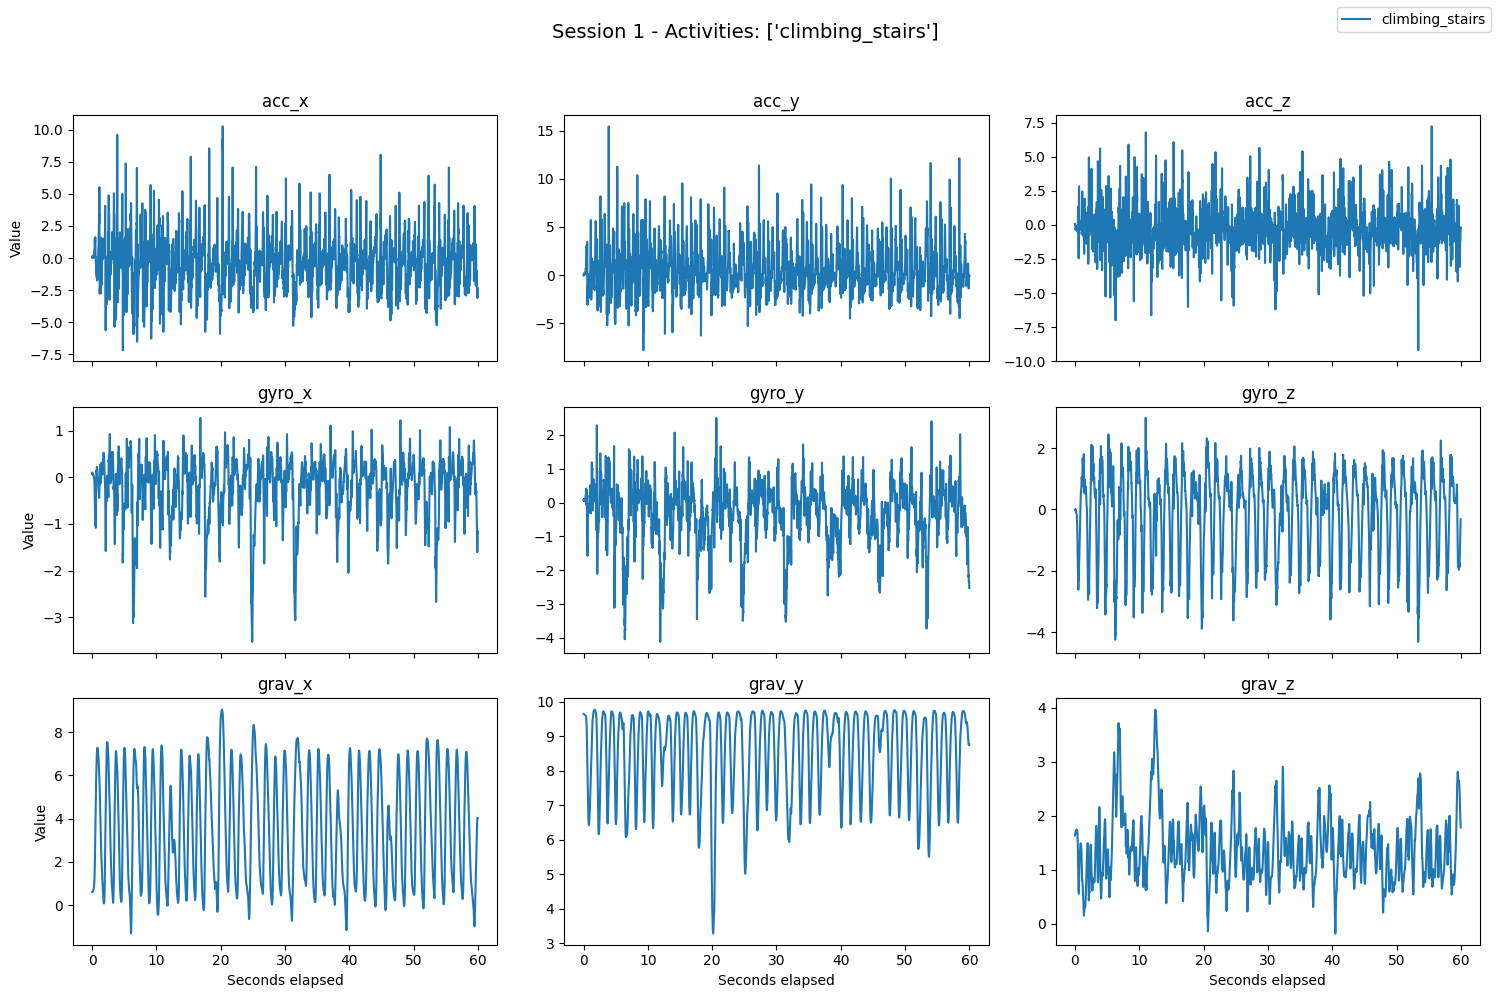

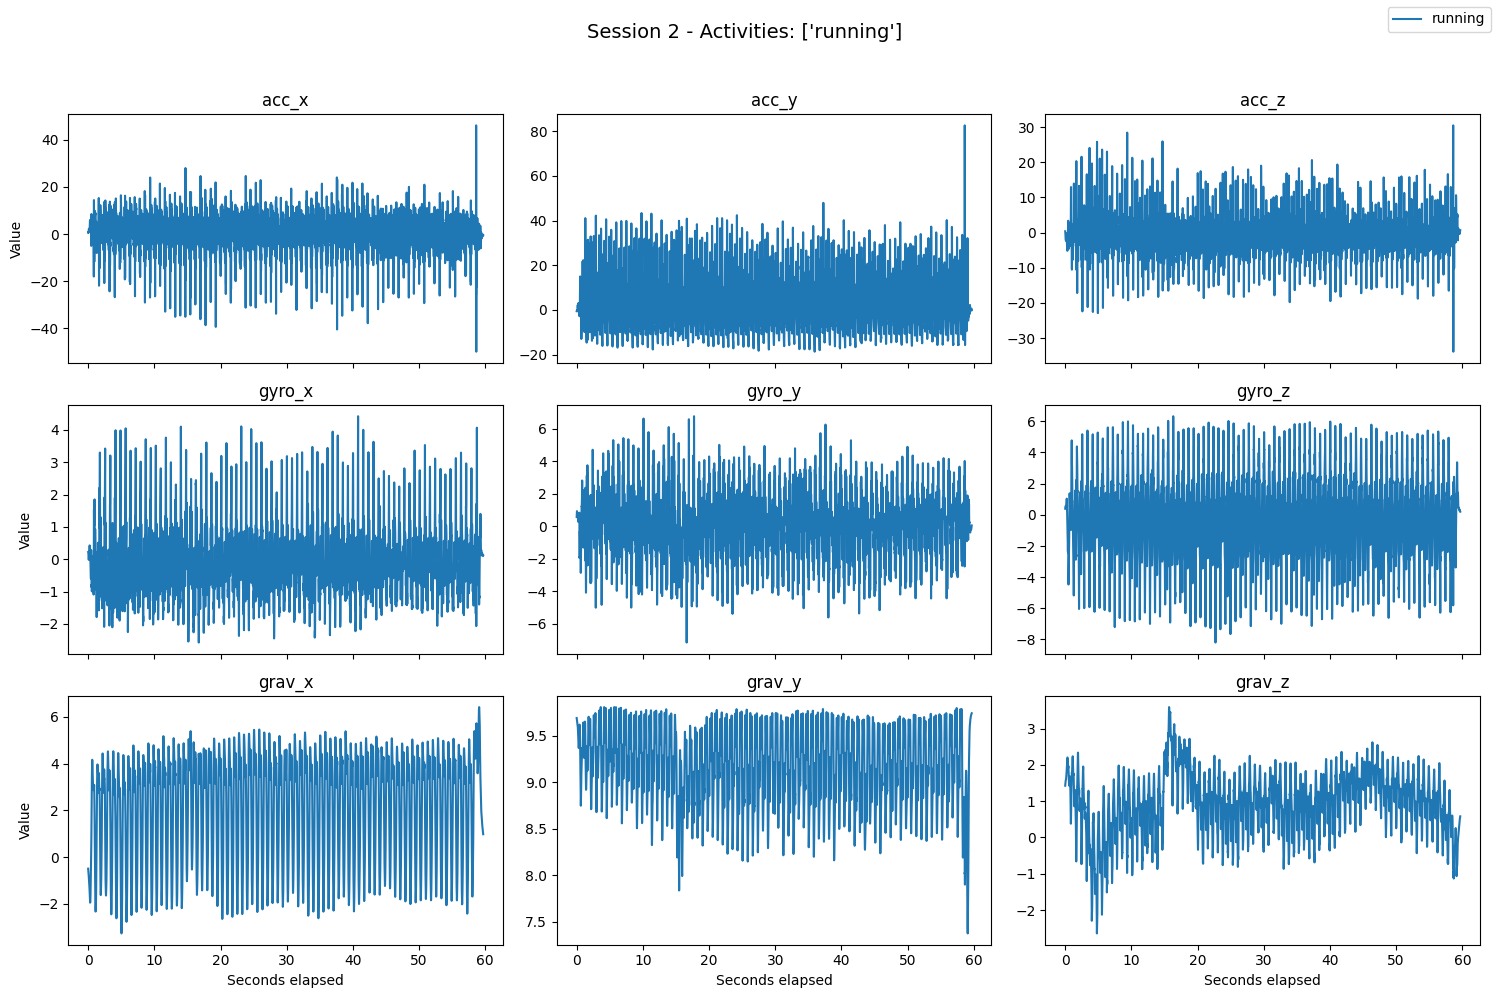

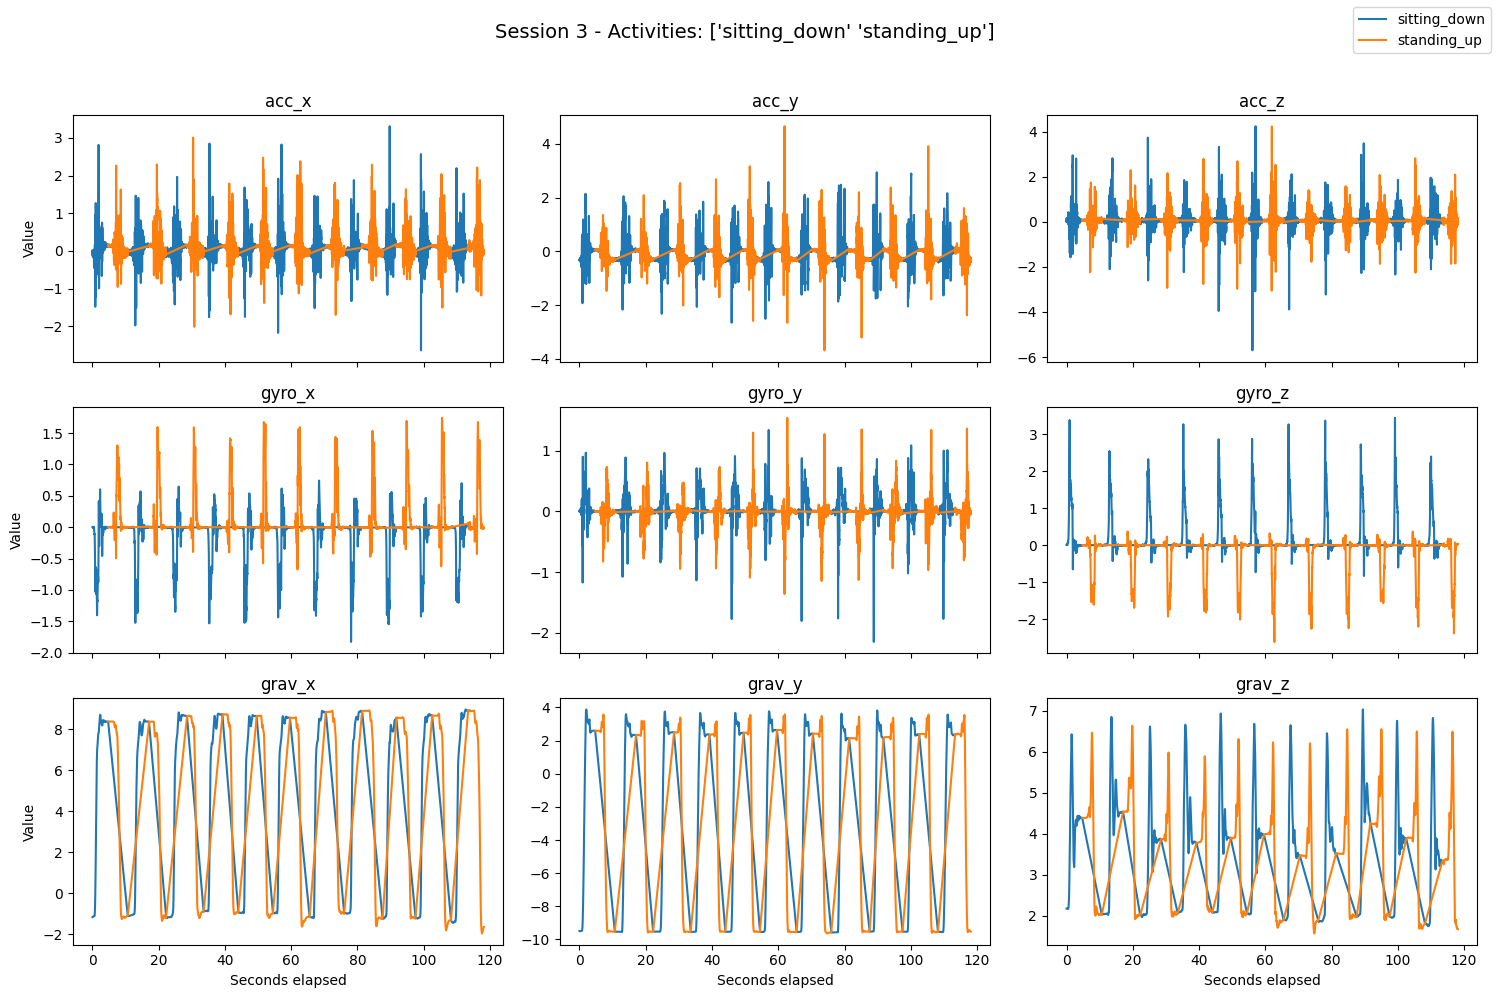

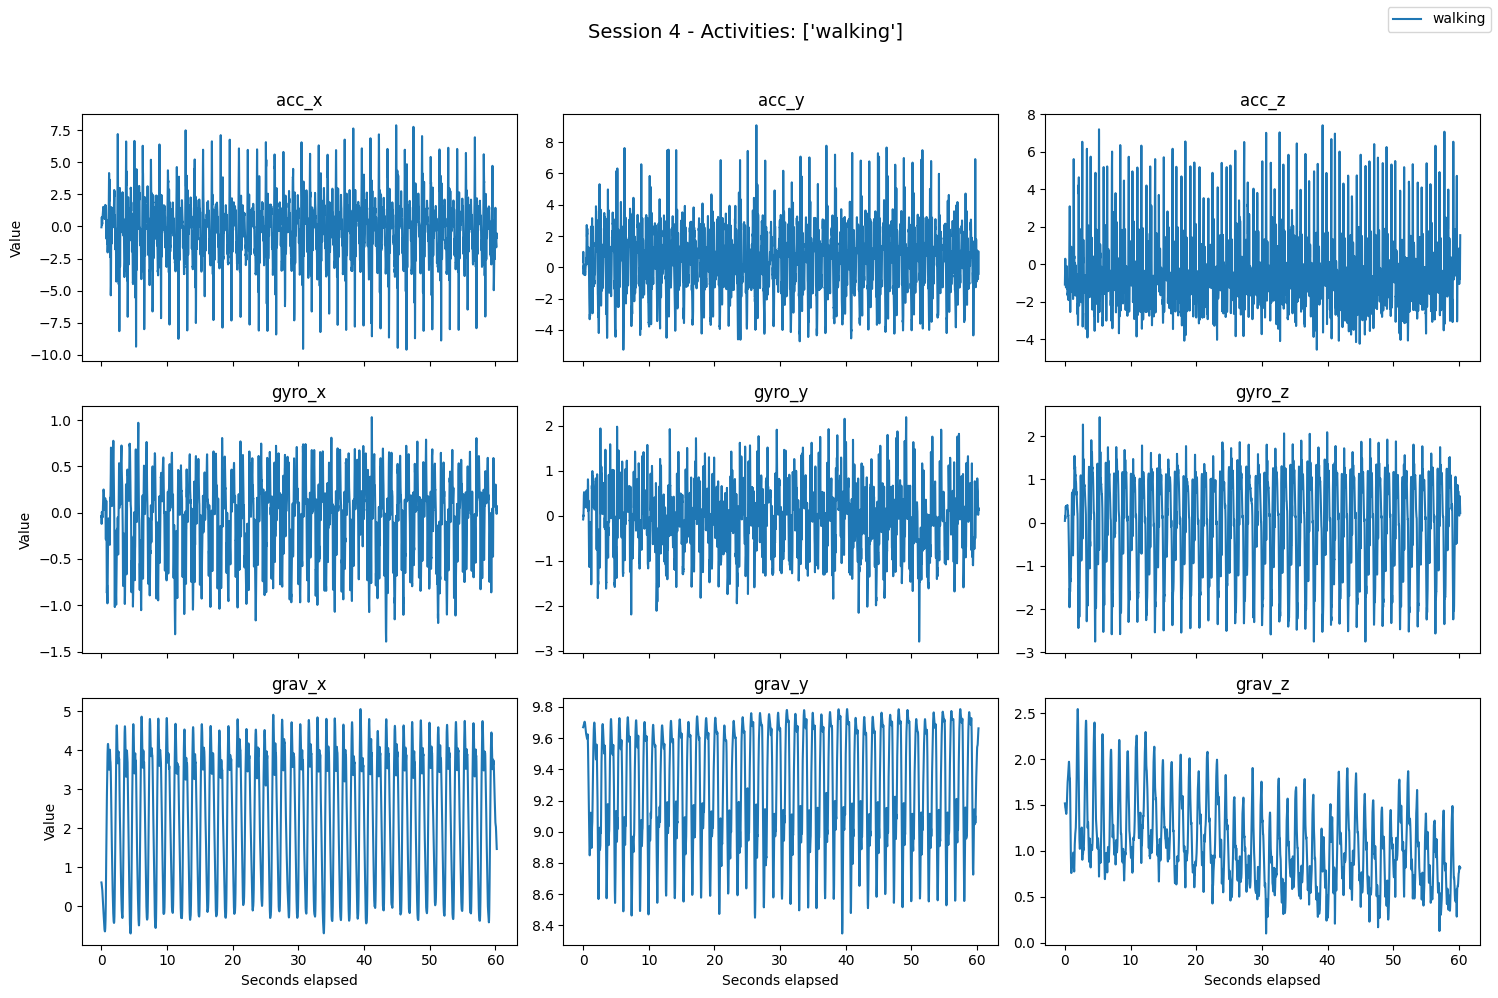

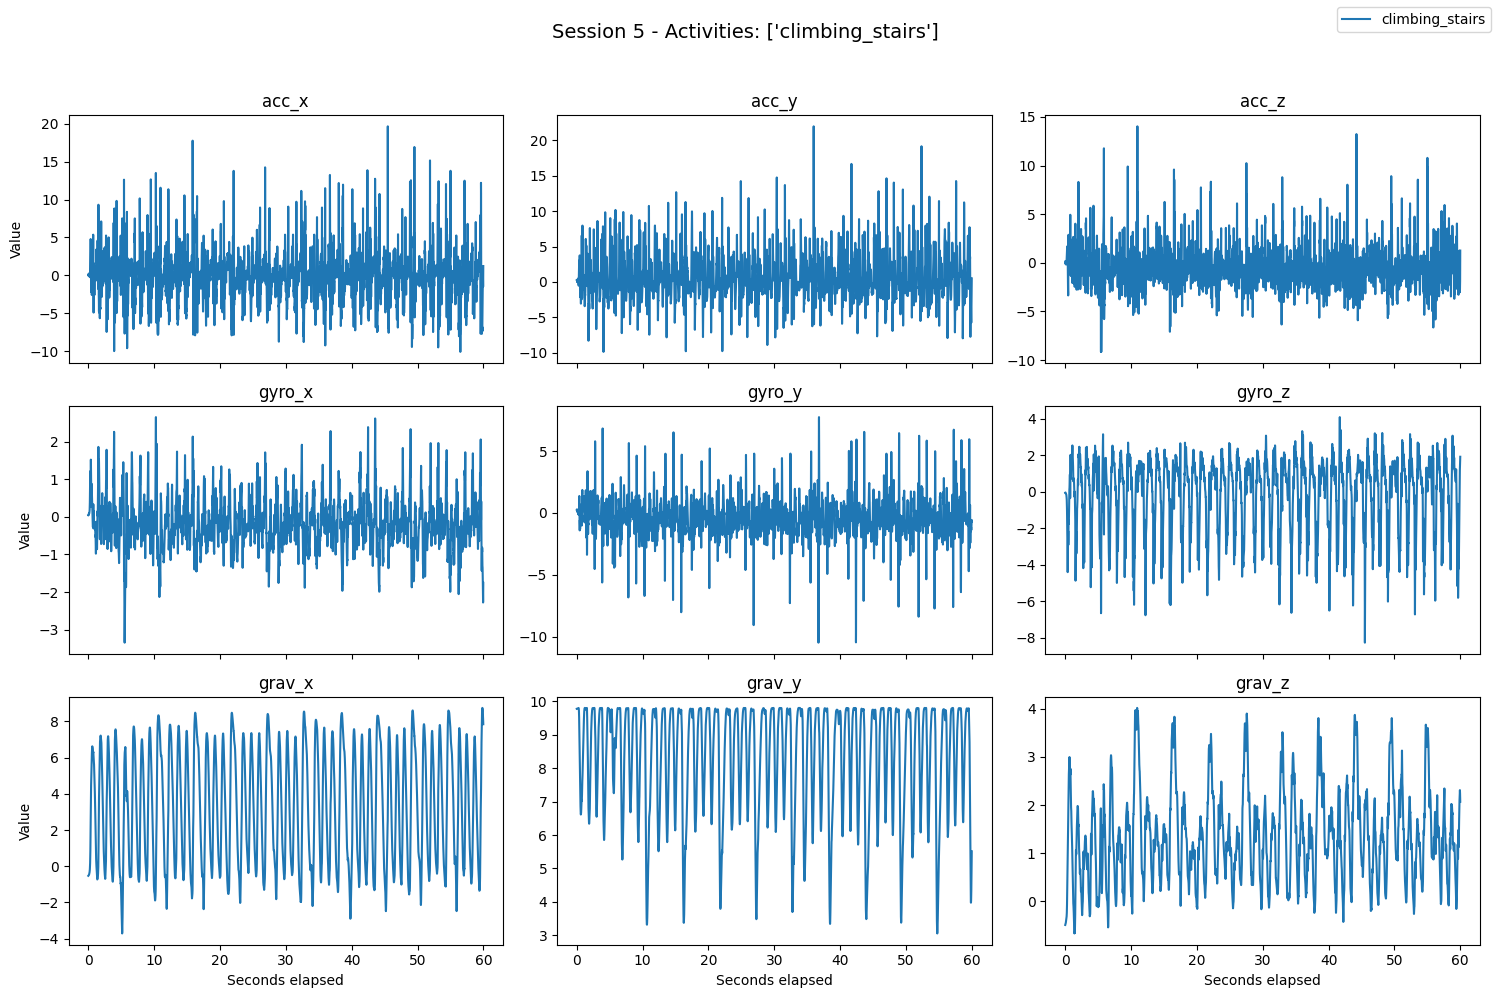

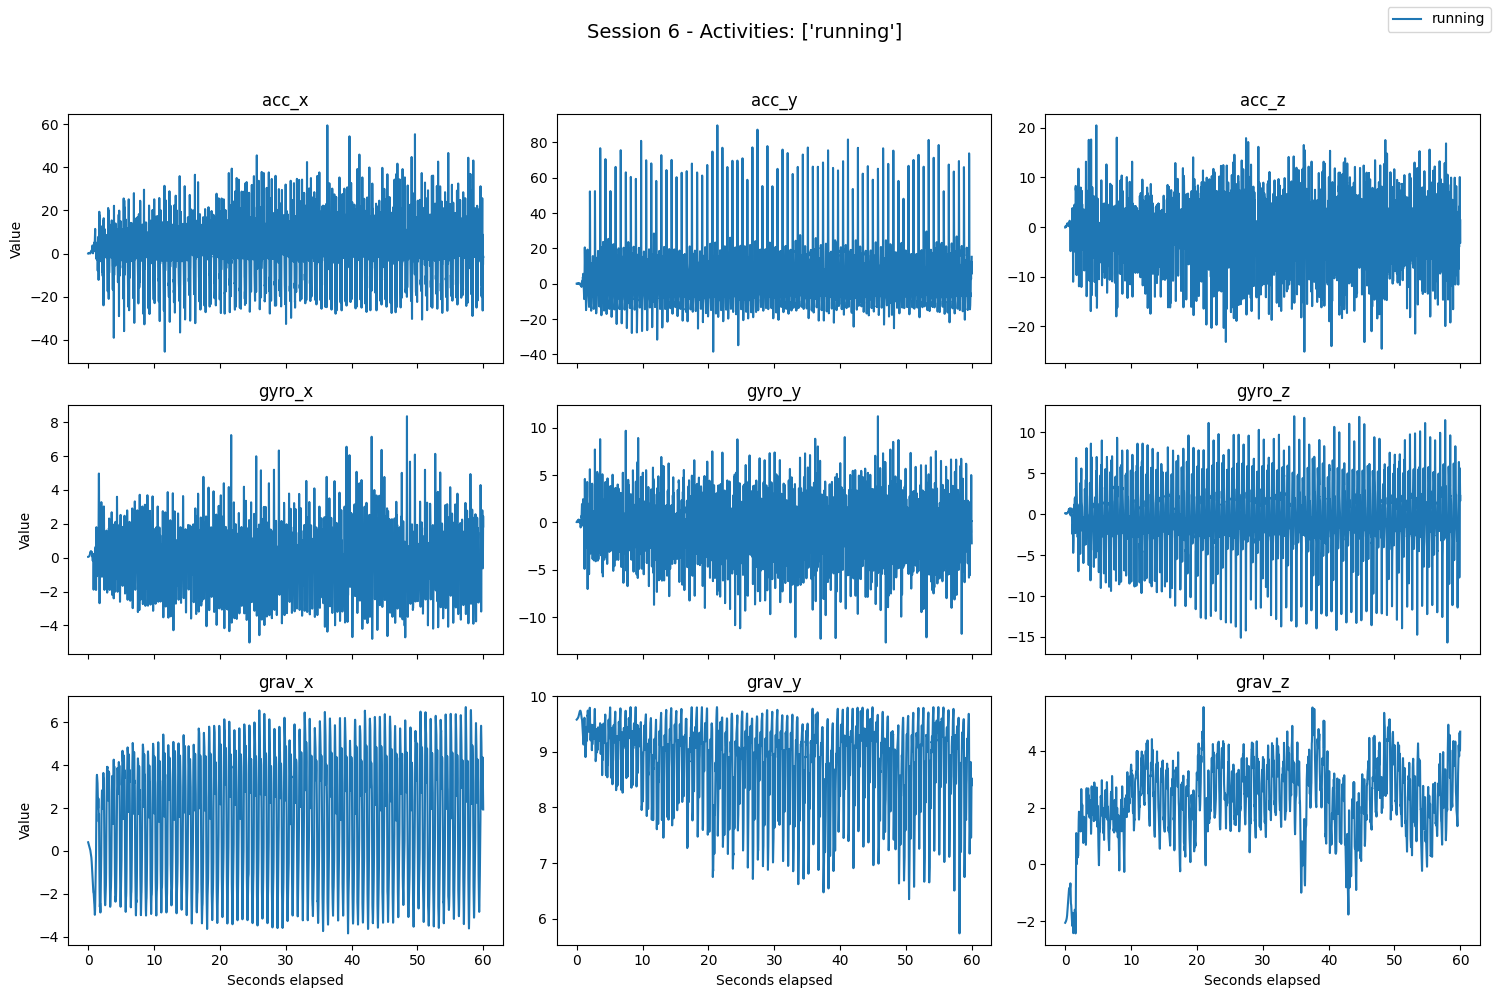

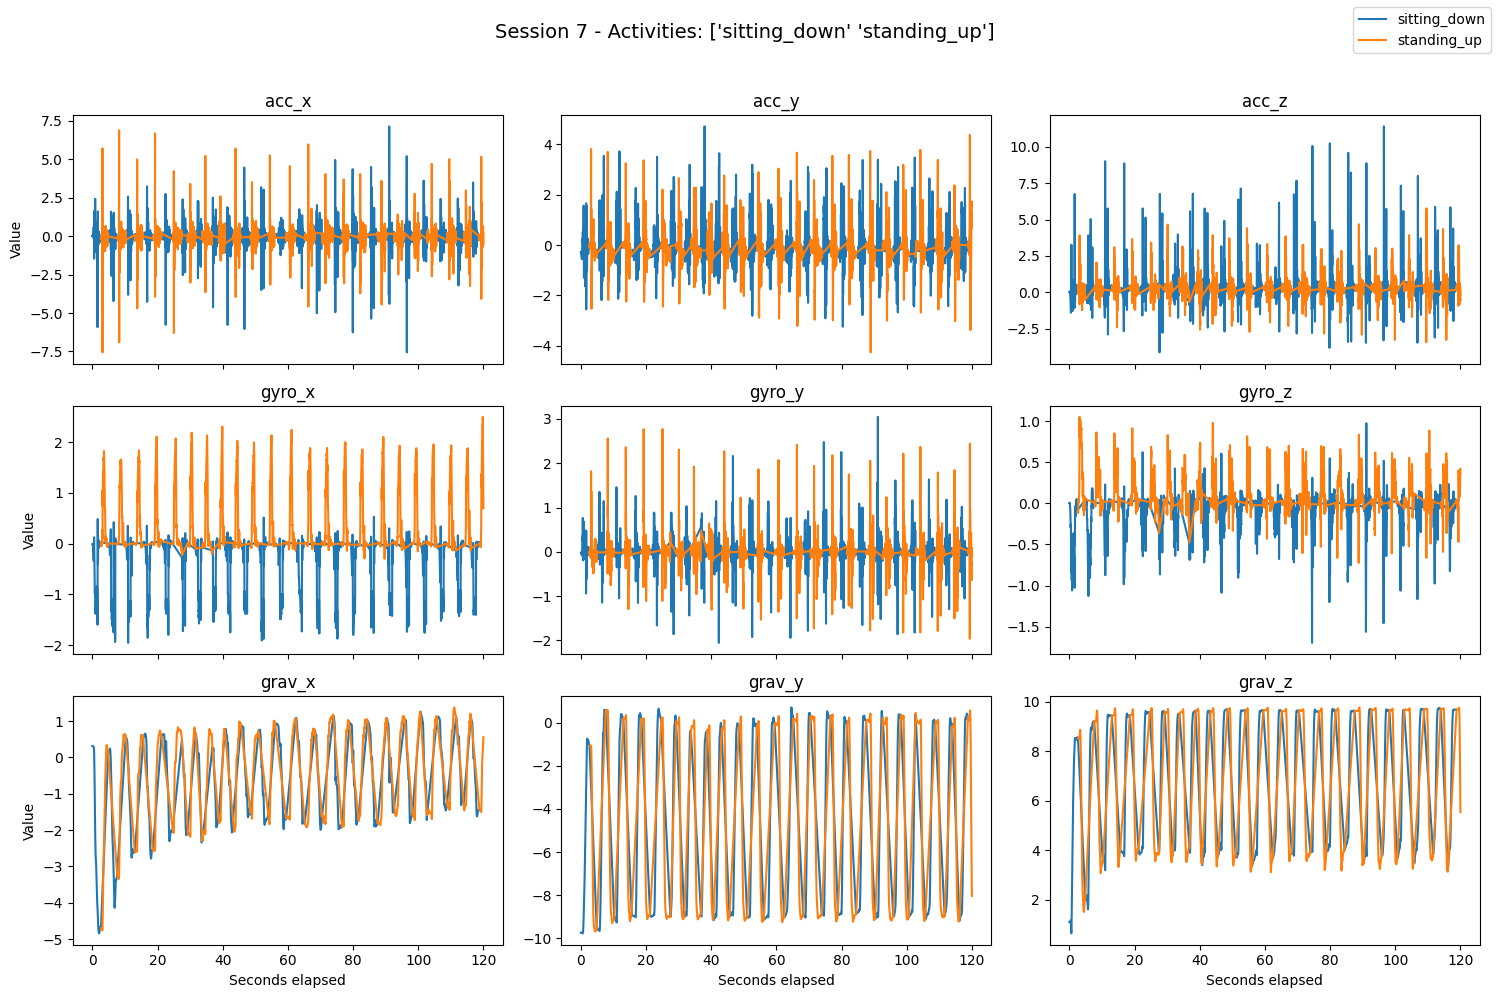

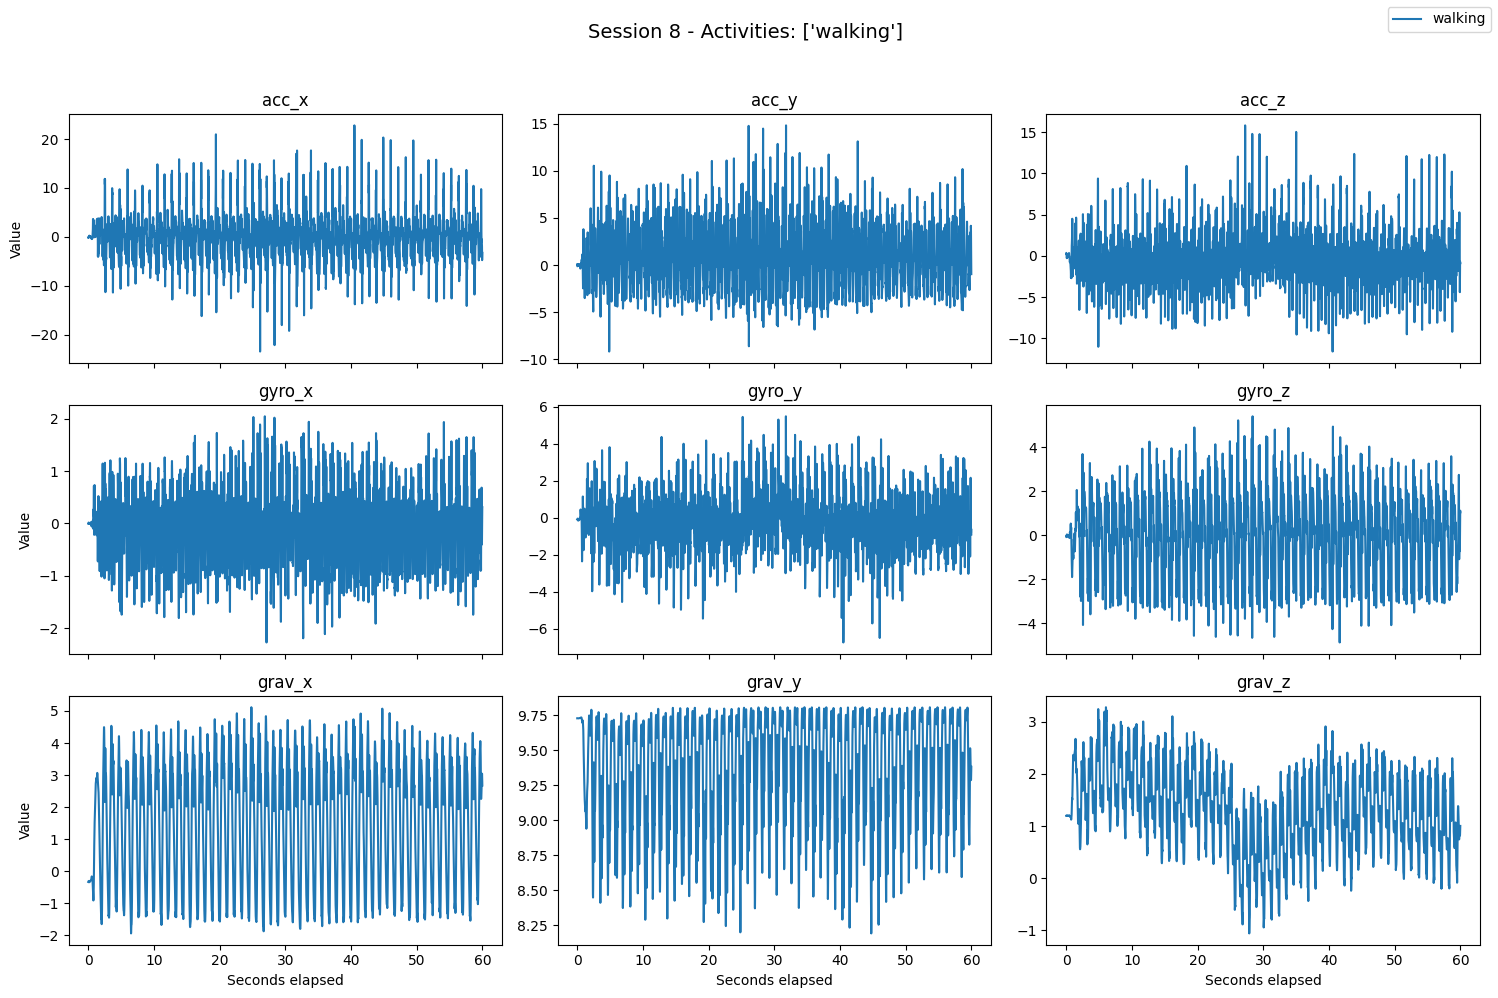

In [367]:
sensors = ["acc", "gyro", "grav"]
axes = ["x", "y", "z"]

# Loop over sessions
for session_id in df["session_id"].unique():
    df_session = df[df["session_id"] == session_id]

    fig, axs = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    fig.suptitle(f"Session {session_id} - Activities: {df_session['label'].unique()}", fontsize=14)

    for i, sensor in enumerate(sensors):
        for j, axis in enumerate(axes):
            col = f"{sensor}_{axis}"
            ax = axs[i, j]

            # plot each activity segment in a different color
            for label in df_session["label"].unique():
                subset = df_session[df_session["label"] == label]
                ax.plot(subset["seconds_elapsed"], subset[col], label=label)

            ax.set_title(col)
            if i == 2:
                ax.set_xlabel("Seconds elapsed")
            if j == 0:
                ax.set_ylabel("Value")

    # Upper-right legend (useful for session 3)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### 3.3. Diagnostics

Missing values are checked by counting NaN entries per column. In case they are not zero, dropping the entries or imputing the values must be considered.

The sampling frequency consistency is validated with Î”t (time difference between samples): `Î”t` â‰ˆ 0.01s at 100 Hz. Moreover, a low standard deviation means stable sampling, while a high std indicates irregular timing or dropped samples.

FFTs are also performed on selected signals to inspect frequency content and justify filtering. They help identify the motion-related band (<15 Hz) versus noise.

In [368]:
def diagnostics(df, fs=100, do_fft=False, fft_session=None, fft_measurements=None):
    """
    Run diagnostics on the dataset:
    - Missing values (all columns)
    - Î”t stats per session
    - Optionally: FFT for one session and selected measurements
    """
    # Check NaN values
    print("ðŸ”¹ Missing values per column:")
    print(df.isna().sum())
    
    # Check frequency per session: seconds_elapsed continuity. Mean should be â‰ˆ 0.01 and std small
    print("\nðŸ”¹ Î”t stats per session:")
    for session_id in df["session_id"].unique():
        df_sess = df[df["session_id"] == session_id]
        diffs = df_sess["seconds_elapsed"].diff().dropna()
        print(f"Session {session_id}: "
              f"mean Î”t = {diffs.mean():.5f}s, "
              f"std = {diffs.std():.5f}s, "
              f"expected ~{1/fs:.3f}s, "
              f"unique Î”t (first 3) = {diffs.unique()[:3]}")
    
    # Optional FFT
    if do_fft and fft_session is not None and fft_measurements is not None:
        df_sess = df[df["session_id"] == fft_session]
        n = len(df_sess)
        freqs = np.fft.rfftfreq(n, d=1/fs)

        cols = 3
        rows = int(np.ceil(len(fft_measurements) / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))

        for i, meas in enumerate(fft_measurements):
            r, c = divmod(i, cols)
            ax = axes[r, c] if rows > 1 else axes[c]
            fft_vals = np.abs(np.fft.rfft(df_sess[meas].values))
            ax.plot(freqs, fft_vals)
            ax.set_title(f"{meas}")
            ax.set_xlim(0, fs/2)
            ax.set_xlabel("Hz")
            ax.set_ylabel("Magnitude")

        plt.suptitle(f"FFT plots (Session {fft_session})", fontsize=14)
        plt.tight_layout()
        plt.show()

ðŸ”¹ Missing values per column:
time               0
seconds_elapsed    0
gyro_x             0
gyro_y             0
gyro_z             0
acc_x              0
acc_y              0
acc_z              0
grav_x             0
grav_y             0
grav_z             0
label              0
session_id         0
label_encoded      0
dtype: int64

ðŸ”¹ Î”t stats per session:
Session 1: mean Î”t = 0.00995s, std = 0.00000s, expected ~0.010s, unique Î”t (first 3) = [0.00995386 0.0099541  0.00995508]
Session 2: mean Î”t = 0.00995s, std = 0.00000s, expected ~0.010s, unique Î”t (first 3) = [0.00995386 0.0099541  0.00995508]
Session 3: mean Î”t = 0.00962s, std = 0.00081s, expected ~0.010s, unique Î”t (first 3) = [0.00955298 0.00955322 0.00955298]
Session 4: mean Î”t = 0.00995s, std = 0.00000s, expected ~0.010s, unique Î”t (first 3) = [0.0099541  0.00995386 0.00995386]
Session 5: mean Î”t = 0.00995s, std = 0.00000s, expected ~0.010s, unique Î”t (first 3) = [0.00995386 0.00995313 0.00995435]
Session 6: m

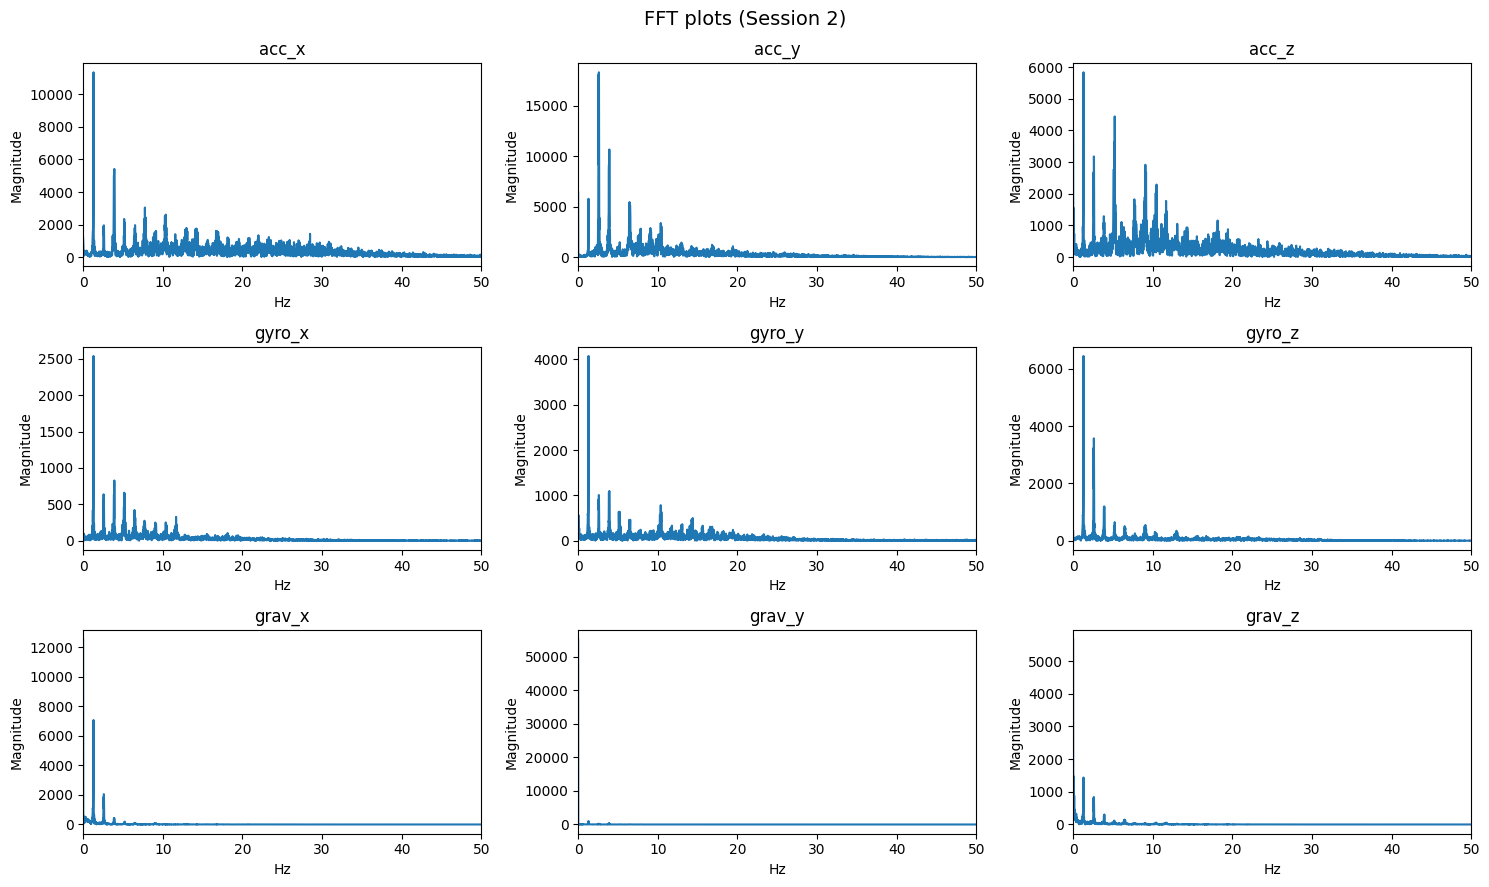

In [369]:
# Extended diagnostics: FFT for session 2 on acc, gyro, grav
diagnostics(
    df,
    fs=100,
    do_fft=True,
    fft_session=2,
    fft_measurements=["acc_x", "acc_y", "acc_z",
                      "gyro_x", "gyro_y", "gyro_z",
                      "grav_x", "grav_y", "grav_z"]
)

Results indicate that a low-pass filter might be needed, mainly shown in acc_x and acc_z graphs. Therefore, we proceed to filtering.

### 3.4. Filtering

Applied a 15 Hz low-pass Butterworth filter to accelerometer and gyroscope signals, since human activity occurs below 15 Hz. 
This is a standard practice in Human Activity Recognition to remove high-frequency noise. 

A band-pass (0.3â€“15 Hz) could have been applied to accelerometer data, but since gravity is already provided separately, 
the low-pass was sufficient and less complex. Gravity channels were left untouched.

In [370]:
def butter_filter(data, cutoff, fs=100, order=4, btype="low"):
    """
    Apply Butterworth filter.
    cutoff : cutoff frequency in Hz
    fs     : sampling frequency (Hz), default 100
    order  : filter order
    btype  : 'low' for low-pass, 'high' for high-pass
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return filtfilt(b, a, data)

In [371]:
# Apply low-pass filtering (15 Hz) to accelerometer & gyroscope
for sensor in ["acc", "gyro"]:
    for axis in ["x", "y", "z"]:
        col = f"{sensor}_{axis}"
        df[col] = butter_filter(df[col], cutoff=15, btype="low")

### 3.5. Post-filter visualizations

A (previously confflictlive) FFT is replotted to confirm that filtering reduced noise while preserving the relevant motion information.  

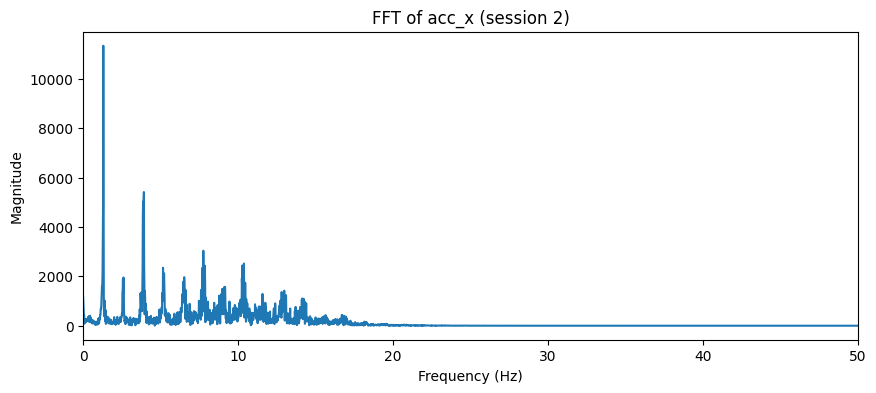

In [372]:
def plot_fft(signal, fs=100, title="FFT"):
    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))

    plt.figure(figsize=(10,4))
    plt.plot(freqs, fft_vals)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xlim(0, 50)  # only show up to 50 Hz (Nyquist = 50Hz at fs=100Hz)
    plt.show()

# We use accelerometer X in the same session as before
df_sess = df[df["session_id"] == 2]
plot_fft(df_sess["acc_x"].values, fs=100, title="FFT of acc_x (session 2)")


Two violin plots are also used to check separability of activities after preprocessing.

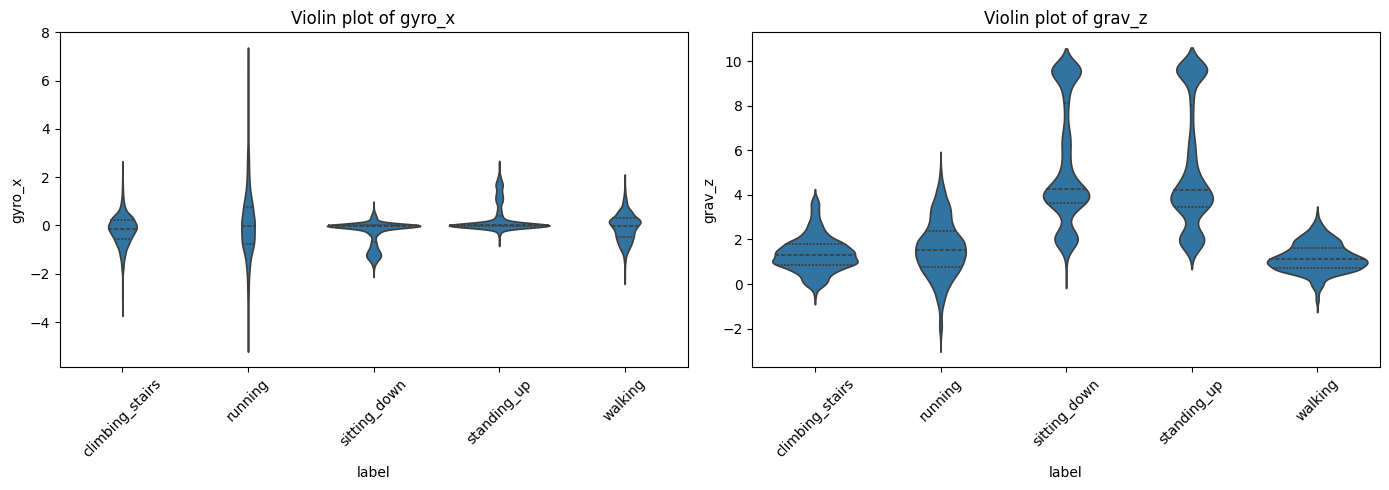

In [373]:
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=False)

sns.violinplot(data=df, x="label", y="gyro_x", inner="quartile", ax=axes[0])
axes[0].set_title("Violin plot of gyro_x")
axes[0].tick_params(axis='x', rotation=45)

sns.violinplot(data=df, x="label", y="grav_z", inner="quartile", ax=axes[1])
axes[1].set_title("Violin plot of grav_z")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Result: the final dataset ready for model training.

## 4. Feature Engineering & Extraction

### Previous preparation: Creating subtrials for each session

By creating this new column, it facilitates window configuration and data leakage can be avoided in feature engineering. In multiple action sessions (transition), a subtrial will be every activity from beggining to end. In continuous sessions with one action, the subtrials are the size of the average length of the previous ones.

In [374]:
df = df.sort_values(["session_id", "time"]).reset_index(drop=True)

# Calculate avg length of short actions
transition_classes = ["sitting_down", "standing_up"]

transition_lengths = []
for session_id, df_sess in df.groupby("session_id", sort=False):
    labels = df_sess["label"].values
    change_idxs = np.where(labels[1:] != labels[:-1])[0] + 1
    boundaries = np.concatenate(([0], change_idxs, [len(labels)]))
    for i in range(len(boundaries) - 1):
        start, end = boundaries[i], boundaries[i + 1]
        label = df_sess.iloc[start]["label"]
        if label in transition_classes:
            transition_lengths.append(end - start)

target_len = int(np.mean(transition_lengths))
print(f"Average duration of short actions: {target_len} samples")

# Define subtrial_id for all dataset
subtrial_ids = []

for session_id, df_sess in df.groupby("session_id", sort=False):
    labels = df_sess["label_encoded"].values
    change_idxs = np.where(labels[1:] != labels[:-1])[0] + 1
    boundaries = np.concatenate(([0], change_idxs, [len(labels)]))
    
    sub_ids_sess = np.zeros(len(df_sess), dtype=object)
    
    for i in range(len(boundaries)-1):
        start, end = boundaries[i], boundaries[i+1]
        label = df_sess.iloc[start]["label"]
        
        if label in transition_classes:
            # transitions have one subtrial per label change 
            sub_id = f"{session_id}_{i}"
            sub_ids_sess[start:end] = sub_id
        else:
            # continuous actions have subtrials of size ~target_len
            n_samples = end - start
            n_blocks = int(np.ceil(n_samples / target_len))
            block_ids = (np.arange(n_samples) // target_len).astype(int)
            for b in range(n_blocks):
                mask = (block_ids == b)
                sub_id = f"{session_id}_{i}_block{b}"
                sub_ids_sess[start:end][mask] = sub_id
    
    subtrial_ids.extend(sub_ids_sess)

df["subtrial_id"] = subtrial_ids

Average duration of short actions: 361 samples


### 4.1. Windowing and Feature extraction

mean, std, min, max, median, skew, RMS â†’ 7 stats per feature

9 raw signals (acc/gyro/grav Ã— 3 axes) â†’ 9 Ã— 7 = 63 features per window

Windows of 3,5s: Tested between 2 and 4 seconds and found an optimum value. Step size stablished at 50% overlap for continuous and 75% for transitions: more windows. There is no overlap between subtrials, which will define the latter split.

In [375]:
def extract_features(df_subset,
                     window_size=240,        # Found optimum at 3,5s (at 100Hz = 350 samples)
                     step_cont_frac=0.5,     # 50% overlap in continous
                     step_trans_frac=0.25,   # 75% overlap in transitions
                     min_fraction=0.8,       # at least 80% of samples same label
                     transition_labels=("sitting_down", "standing_up")):
    features, labels, groups = [], [], []

    drop_cols = ["time","seconds_elapsed","label","session_id","label_encoded","subtrial_id"]
    for subtrial_id, df_sub in df_subset.groupby("subtrial_id", sort=False): # loop per subtrial
        sub_labels = df_sub["label"].values
        maj_label_sub = pd.Series(sub_labels).mode()[0]
        is_transition = maj_label_sub in transition_labels

        # adaptative step
        step_size = max(1, int(window_size * (step_trans_frac if is_transition else step_cont_frac)))

        X_sub = df_sub.drop(columns=[c for c in drop_cols if c in df_sub.columns]).select_dtypes(include=[np.number])
        y_sub = df_sub["label_encoded"].values

        for start in range(0, len(X_sub) - window_size + 1, step_size):
            end = start + window_size
            window = X_sub.iloc[start:end]
            window_labels = y_sub[start:end]

            # skip windows with <80% same label
            majority_label = pd.Series(window_labels).mode()[0]
            if (window_labels == majority_label).mean() < min_fraction:
                continue

            feats = []
            for col in window.columns:
                vals = window[col].values.astype(float)
                feats.extend([
                    vals.mean(),
                    vals.std(),
                    vals.min(),
                    vals.max(),
                    np.median(vals),
                    skew(vals),
                    np.sqrt(np.mean(vals**2))  # RMS
                ])

            features.append(feats)
            labels.append(majority_label)
            groups.append(subtrial_id)

    X_feat = pd.DataFrame(features)
    y_feat = np.array(labels)
    groups = np.array(groups)
    return X_feat, y_feat, groups

In [376]:
X_feat, y_feat, groups = extract_features(df)

print("Feature matrix shape:", X_feat.shape)
print("Labels distribution:", np.bincount(y_feat))

Feature matrix shape: (373, 63)
Labels distribution: [66 65 87 89 66]


### 4.2. Plot Mutual Information and RFE

This is just to have an idea for the future pipeline, and will not replace it.

#### 4.2.1. Scaling

Filtered features are standardized (zero mean, unit variance) so all sensor axes are on the same scale. 

This ensures features with larger magnitudes  donâ€™t dominate the model.

In [377]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

print("Scaled feature matrix shape:", X_scaled.shape)

Scaled feature matrix shape: (373, 63)


#### 4.2.2. Filter feature scaling (Mutual Information)

Measures how much each feature reduces uncertainty about the class label. This is because features with higher MI are more discriminative for separating activities. Provides a visual plot to determine where to establish k.

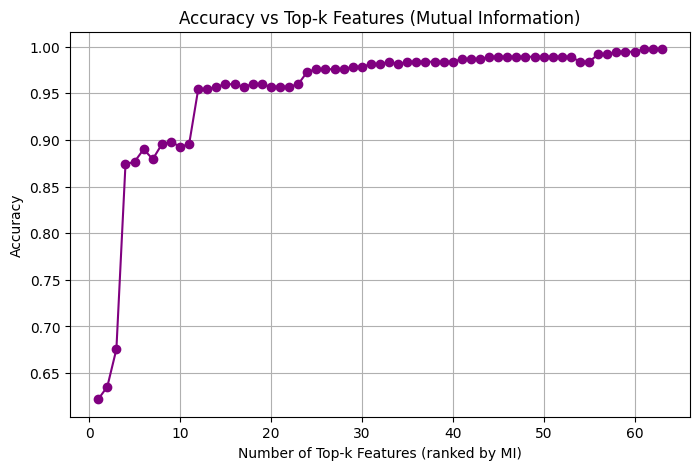

In [ ]:
mi_scores = mutual_info_classif(X_scaled, y_feat, random_state=42)
feature_ranking = np.argsort(mi_scores)[::-1]

accuracy_list = []
for k in range(1, X_scaled.shape[1] + 1):
    top_k = feature_ranking[:k]
    model = LogisticRegression(max_iter=5000, solver="saga")
    model.fit(X_scaled[:, top_k], y_feat)   # fitting on full data, just exploratory
    y_pred = model.predict(X_scaled[:, top_k])
    accuracy_list.append(accuracy_score(y_feat, y_pred))

plt.figure(figsize=(8,5))
plt.plot(range(1, X_scaled.shape[1] + 1), accuracy_list,
         marker="o", color="purple")
plt.xlabel("Number of Top-k Features (ranked by MI)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Top-k Features (Mutual Information)")
plt.grid(True)
plt.show()

#### 4.2.3. Wrapper feature selection (RFE)

Iteratively trains a model (here: Logistic Regression), removes the least important features, and repeats until only the best features remain.

This is wrapper method, which selects features based on model performance, not just statistics. We will keep the features decided after the plot visualization.

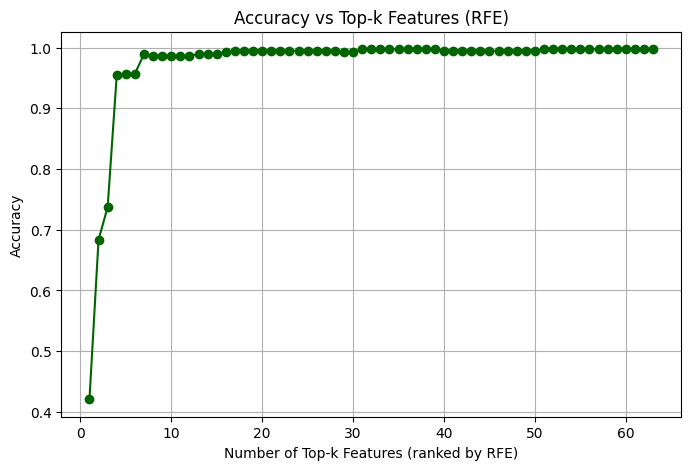

In [379]:
# Logistic Regression as estimator
estimator = LogisticRegression(max_iter=5000, solver="saga")

rfe = RFE(estimator, n_features_to_select=1, step=1)  # start by ranking all
rfe.fit(X_scaled, y_feat)

# Ranking of features (1 = most important)
ranking = rfe.ranking_

# To build the curve: re-fit models incrementally with top-k ranked features
feature_ranking_rfe = np.argsort(ranking)  # order of features by RFE

accuracy_list_rfe = []
for k in range(1, X_scaled.shape[1] + 1):
    top_k = feature_ranking_rfe[:k]
    model = LogisticRegression(max_iter=5000, solver="saga")
    model.fit(X_scaled[:, top_k], y_feat)
    y_pred = model.predict(X_scaled[:, top_k])
    accuracy_list_rfe.append(accuracy_score(y_feat, y_pred))

plt.figure(figsize=(8,5))
plt.plot(range(1, X_scaled.shape[1] + 1), accuracy_list_rfe,
         marker="o", color="darkgreen")
plt.xlabel("Number of Top-k Features (ranked by RFE)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Top-k Features (RFE)")
plt.grid(True)
plt.show()

## 5. Cross Validation and Splitting

CV provides an estimate of model stability by training and testing across multiple folds, while a single train/test split simulates real deployment by holding out unseen data for final evaluation.


### 5.1. Cross Validation

It is applied to evaluate model performance and stability. 

-----Text to modify----
Since each session typically contains only one activity, `GroupKFold` is not suitable (it would leave out unseen classes).  
Instead, we use `StratifiedKFold`, which ensures that each fold preserves the label distribution, giving a fair estimate of how well the models generalize across balanced splits.

In [380]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="saga"),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "K Nearest Neighbours": KNeighborsClassifier()
}

# CV by subtrial groups
cv = GroupKFold(n_splits=5)

print("Cross-validation results (F1-weighted, GroupKFold by subtrial):")
for name, clf in models.items():
    if name in ["Naive Bayes", "K Nearest Neighbours"]:
        rfe_estimator = LogisticRegression(max_iter=5000, solver="saga")
    else:
        rfe_estimator = clf

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mi", SelectKBest(mutual_info_classif, k=41)),  # tried different k for MI and n for RFE
        ("rfe", RFE(rfe_estimator, n_features_to_select=17, step=0.1)),
        ("clf", clf)
    ])

    scores = cross_val_score(
        pipe,
        X_feat, y_feat,
        cv=cv,
        groups=groups,
        scoring="f1_weighted"
    )

    print(f"{name:20s}: {scores.mean():.3f} Â± {scores.std():.3f}")


Cross-validation results (F1-weighted, GroupKFold by subtrial):
Logistic Regression : 0.973 Â± 0.014
Decision Tree       : 0.971 Â± 0.027
Naive Bayes         : 0.976 Â± 0.015
K Nearest Neighbours: 0.976 Â± 0.022


The reported metric is **F1-weighted**, which balances precision and recall across all classes, taking class frequencies into account.  
This is more informative than accuracy when classes are not perfectly balanced.  
Results around 0.95 show that our statistical features provide strong discrimination between activities, with low variability across folds (Â± values), meaning the models are stable.

### 5.2. Splitting
After validating our features and models through cross-validation, we move to a supervised learning setup with a train/test split.  
This allows us to train a final model on the training set and evaluate it on a held-out test set, simulating performance on unseen data.

There is no overlap because it was defined that way in the features engineering. With StratifiedShuffleSplit and grouping by label we make each subtrial (and all its windows) go either into train or test. Each subtrial is a group, as defined in feature extraction.

In [381]:
# Each group has a majority label (all windows in a subtrial should have same label)
unique_groups = pd.DataFrame({
    "group": groups,
    "label": y_feat
}).drop_duplicates("group")

gss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_groups_idx, test_groups_idx = next(
    gss.split(unique_groups["group"], unique_groups["label"])
)

train_groups = set(unique_groups.iloc[train_groups_idx]["group"])
test_groups  = set(unique_groups.iloc[test_groups_idx]["group"])

train_idx = [i for i, g in enumerate(groups) if g in train_groups]
test_idx  = [i for i, g in enumerate(groups) if g in test_groups]

X_train, X_test = X_feat.iloc[train_idx], X_feat.iloc[test_idx]
y_train, y_test = y_feat[train_idx], y_feat[test_idx]

print("Train windows:", len(train_idx))
print("Test windows:", len(test_idx))
print("Train label window distribution:", np.bincount(y_train))
print("Test label window distribution:", np.bincount(y_test))

Train windows: 302
Test windows: 71
Train label window distribution: [53 52 68 77 52]
Test label window distribution: [13 13 19 12 14]


In [382]:
df_windows = pd.DataFrame({
    "label": y_feat,
    "group": groups
})

print("Total train groups:", len(train_groups))
print("Total test groups :", len(test_groups))
print("\nGroup counts (train):")
print(df_windows[df_windows["group"].isin(train_groups)]
    .drop_duplicates("group")["label"].value_counts()
    )
print("\nGroup counts (test):")
print(df_windows[df_windows["group"].isin(test_groups)]
    .drop_duplicates("group")["label"].value_counts()
    )

Total train groups: 126
Total test groups : 32

Group counts (train):
label
0    27
4    27
1    26
2    23
3    23
Name: count, dtype: int64

Group counts (test):
label
0    7
1    7
4    7
2    6
3    5
Name: count, dtype: int64


## 6. Supervised Learning

Here, we will train Logistic Regression, Decision Tree, Naive Bayes, and KNN on the training set and evaluate on the test set.   

### 6.1. Calculation and Summary of Metrics

Performance is reported using Accuracy, F1-weighted, and Cohenâ€™s Kappa. The performance values for each case can be compared in the summary table. We use a pipeline similar to the one in Cross Validation. 

In [383]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="saga"),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "K Nearest Neighbours": KNeighborsClassifier()
}

results = {}

for name, clf in models.items():
    # Choosing an RFE estimator (LR if clf doesnâ€™t have coef_/feature_importances_)
    if name in ["Naive Bayes", "K Nearest Neighbours"]:
        rfe_estimator = LogisticRegression(max_iter=5000, solver="saga")
    else:
        rfe_estimator = clf

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mi", SelectKBest(mutual_info_classif, k=41)),
        ("rfe", RFE(rfe_estimator, n_features_to_select=17, step=0.1)),
        ("clf", clf)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds, average="weighted"),
        "Kappa": cohen_kappa_score(y_test, preds),
        "Confusion": confusion_matrix(y_test, preds),
        "Report": classification_report(
            y_test, preds,
            target_names=le.classes_,
            output_dict=True
        )
    }
    
summary = pd.DataFrame({m: {k: round(v[k],3) for k in ["Accuracy","F1","Kappa"]} 
                        for m,v in results.items()}).T
print("Summary of metrics:")
display(summary)

Summary of metrics:


Accuracy     F1  Kappa
Logistic Regression      0.958  0.958  0.947
Decision Tree            0.986  0.986  0.982
Naive Bayes              0.958  0.958  0.947
K Nearest Neighbours     0.958  0.958  0.947

#### Interpreting results  
- **Accuracy** shows the overall correctness, but can be misleading with imbalanced classes.  
- **F1-weighted** accounts for precision and recall per class, making it the main metric we focus on.  
- **Cohenâ€™s Kappa** adjusts for chance agreement, confirming reliability beyond accuracy.  (1.0 = perfect agreement, 0 = random guessing)
- **Confusion matrices** reveal which activities are confused with each other. Normalized values make it easier to compare per-class performance independent of class frequency.

Interpretation: High accuracy, strong features (high F1). Kappa â‰ˆ F1 â†’ performance isnâ€™t inflated by chance; the agreement is robust.

### 6.2. Absolute Confusion Matrixes

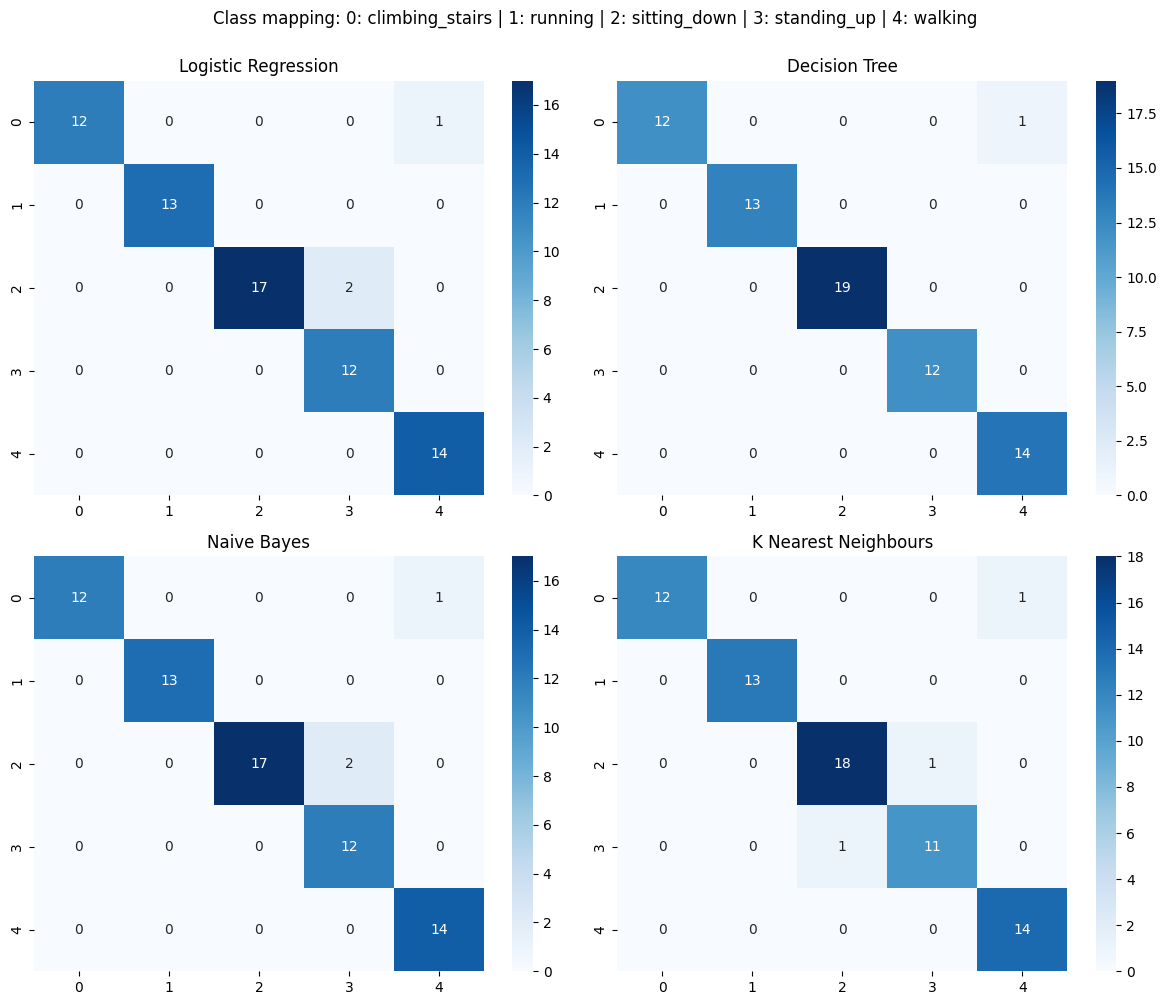

In [384]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, (name, res) in zip(axes.flatten(), results.items()):
    sns.heatmap(res["Confusion"], annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(f"{name}")

labels = " | ".join([f"{i}: {lab}" for i, lab in enumerate(le.classes_)])
fig.suptitle(f"Class mapping: {labels}", fontsize=12, y=1)

plt.tight_layout()
plt.show()

### 6.3. Normalized Confusion Matrixes

A more comprehensive view is given here, where the proportion of correctly and incorrectly predicted samples for each class and each method is shown.

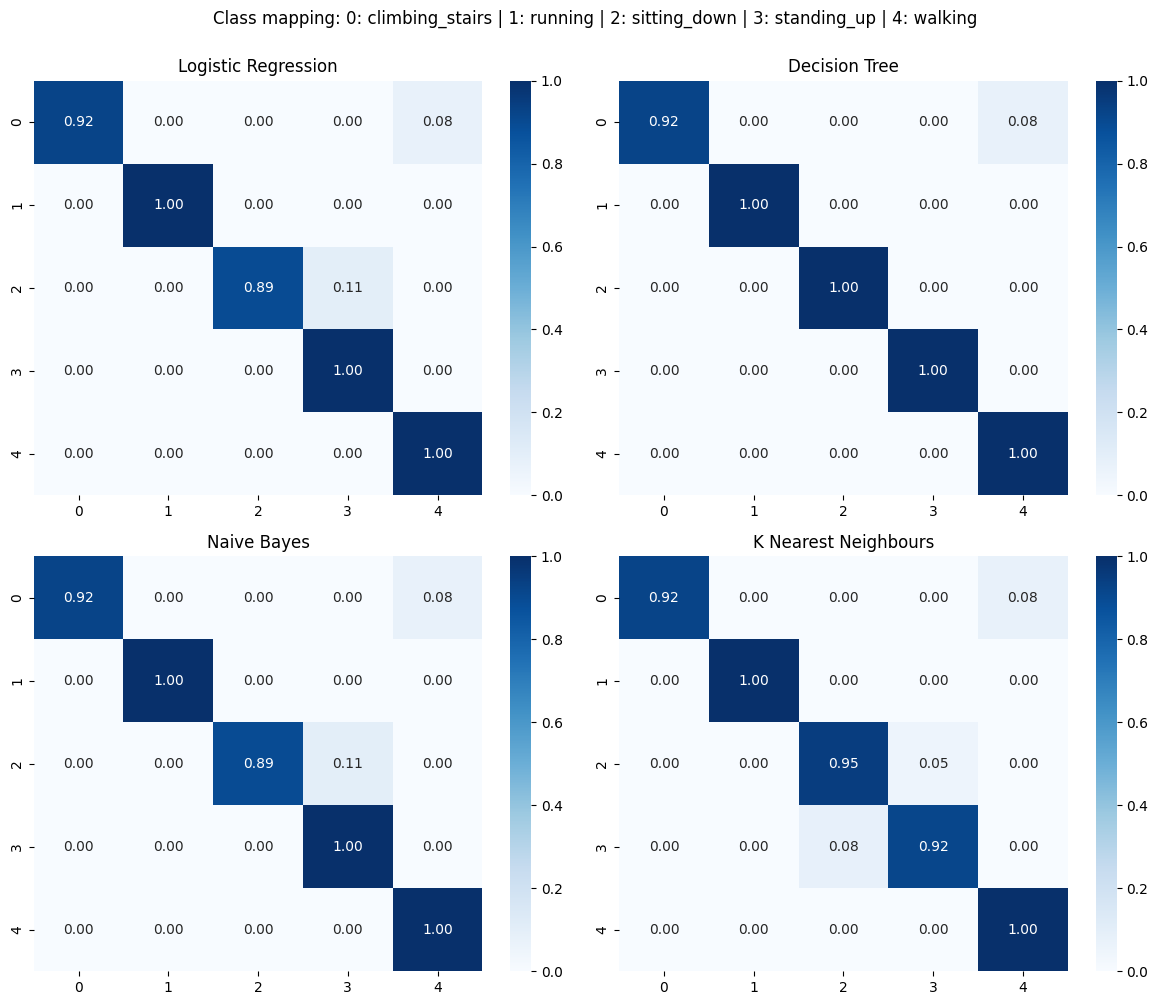

In [385]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, (name, res) in zip(axes.flatten(), results.items()):
    cm_norm = res["Confusion"] / res["Confusion"].sum(axis=1)[:, None]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", ax=ax, cmap="Blues")
    ax.set_title(f"{name}")

labels = " | ".join([f"{i}: {lab}" for i, lab in enumerate(le.classes_)])
fig.suptitle(f"Class mapping: {labels}", fontsize=12, y=1)

plt.tight_layout()
plt.show()

#### (Another) Results explanation

- Logistic regression benefits from scaling and well-engineered features. Implies that our features separate classes almost linearly. 

- Trees handle mixed features well. Single trees tend to overfit more easily than ensembles.

- Naive Bayes sometimes suffers when features are correlated. The high result means that the features are relatively independent and discriminative across classes. It can be luck too.

- KNN can struggle when classes overlap in feature space (walking vs. standing_up, both being moderate-intensity movements). When added scaling, results are improved significantly. Works well because nearby windows in feature space belong to the same activity.

## 7. Unsupervised Learning

In [386]:
# Scale features for clustering
scaler = StandardScaler()
X_scaled_uns = scaler.fit_transform(X_feat)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_uns)

# K-Means
kmeans = KMeans(n_clusters=len(le.classes_), random_state=42).fit(X_scaled_uns)
kmeans_labels = kmeans.labels_

# Gaussian Mixture
gmm = GaussianMixture(n_components=len(le.classes_), random_state=42).fit(X_scaled_uns)
gmm_labels = gmm.predict(X_scaled_uns)

# Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_scaled_uns.T, c=len(le.classes_), m=2, error=0.005, maxiter=1000, init=None)
fcm_labels = np.argmax(u, axis=0)

unsup_labels = {"KMeans": kmeans_labels, "GMM": gmm_labels, "FuzzyCMeans": fcm_labels}

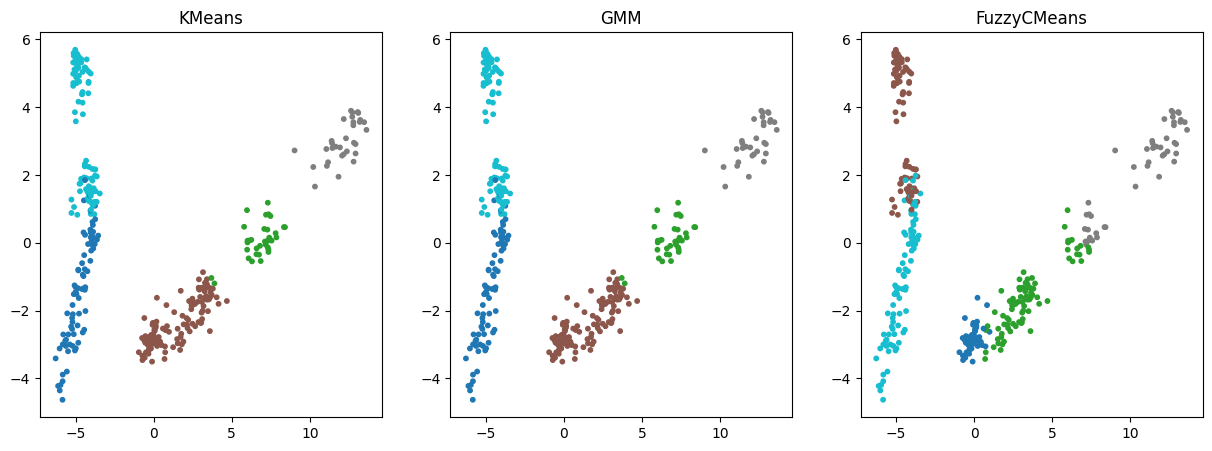

In [387]:
# Plot clustering results in PCA space
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax,(name, labels_) in zip(axes, unsup_labels.items()):
    scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_, cmap="tab10", s=10)
    ax.set_title(name)
plt.show()

In [388]:
for name, labels_ in unsup_labels.items():
    ari = adjusted_rand_score(y_feat, labels_)
    nmi = normalized_mutual_info_score(y_feat, labels_)
    sil = silhouette_score(X_feat, labels_)
    print(f"{name:12s} ARI={ari:.3f}, NMI={nmi:.3f}, Silhouette={sil:.3f}")


KMeans       ARI=0.456, NMI=0.656, Silhouette=0.541
GMM          ARI=0.456, NMI=0.656, Silhouette=0.541
FuzzyCMeans  ARI=0.380, NMI=0.575, Silhouette=0.330


Interpretation:
- ARI ~0.61 â†’ clustering is moderately aligned with true labels (better than random, but not perfect).
- NMI ~0.73 â†’ strong information overlap between clusters and true activities.
- Silhouette ~0.41 â†’ clusters are reasonably compact and separated.
- KMeans and GMM performing equally well makes sense (both assume roughly spherical clusters).
- FCM worse â†’ itâ€™s more sensitive to initialization and fuzziness (membership overlap).

## 8. Model Comparison (not modified yet)

In [389]:
# Supervised comparison table
supervised_df = pd.DataFrame(results).T[["Accuracy","F1","Kappa"]]
print(supervised_df)

# Example unsupervised evaluation: Adjusted Rand Index vs true labels
from sklearn.metrics import adjusted_rand_score

unsup_scores = {name: adjusted_rand_score(y_feat, labels_) for name, labels_ in unsup_labels.items()}
unsup_scores

                      Accuracy        F1     Kappa
Logistic Regression   0.957746  0.958009  0.946949
Decision Tree         0.985915  0.985877  0.982254
Naive Bayes           0.957746  0.958009  0.946949
K Nearest Neighbours  0.957746  0.957708  0.946763


{'KMeans': 0.4562529942782453,
 'GMM': 0.4562529942782453,
 'FuzzyCMeans': 0.3796413954620189}

## Evaluation

In [390]:
# Identify best model
best_model = supervised_df["Accuracy"].idxmax()
print("Best performing supervised model:", best_model)

# Save summary
#supervised_df.to_csv("../data/supervised_results.csv")
#pd.DataFrame.from_dict(unsup_scores, orient="index", columns=["ARI"]).to_csv("../data/unsupervised_results.csv")

Best performing supervised model: Decision Tree
